* In order to Obtain a Better Backbone enabling Video Processing Power, We need to be able to evalute backbone's performances for some specific tasks -- Here we start with a CIFAR10 classification

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import time
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--name', type=str, default="ConvMixer")

parser.add_argument('--batch-size', default=512, type=int)
parser.add_argument('--scale', default=0.75, type=float)
parser.add_argument('--reprob', default=0.25, type=float)
parser.add_argument('--ra-m', default=8, type=int)
parser.add_argument('--ra-n', default=1, type=int)
parser.add_argument('--jitter', default=0.1, type=float)

parser.add_argument('--hdim', default=256, type=int)
parser.add_argument('--depth', default=8, type=int)
parser.add_argument('--psize', default=2, type=int)
parser.add_argument('--conv-ks', default=5, type=int)

parser.add_argument('--wd', default=0.01, type=float)
parser.add_argument('--clip-norm', action='store_true')
parser.add_argument('--epochs', default=25, type=int)
parser.add_argument('--lr-max', default=0.01, type=float)
parser.add_argument('--workers', default=2, type=int)

args = parser.parse_args([])

In [4]:
from convmixer import ConvMixer

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

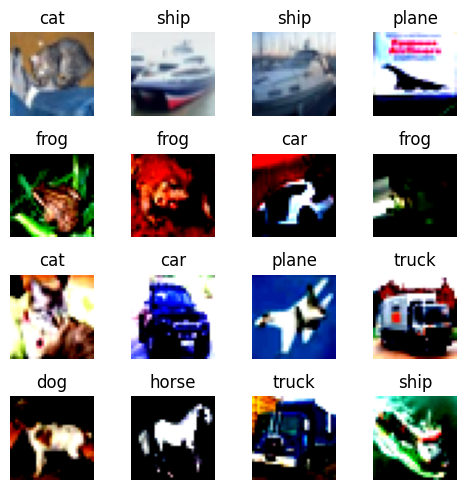

In [64]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(args.scale, 1.0), ratio=(1.0,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=args.ra_n, magnitude=args.ra_m),
    transforms.ColorJitter(args.jitter, args.jitter, args.jitter),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=args.reprob)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='/mnt/d/Data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=args.workers)

testset = torchvision.datasets.CIFAR10(root='/mnt/d/Data', train=False,
                                       download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=args.workers)

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.denormalize(tensor.clone())

    def denormalize(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Function to show a batch of images
def imshow_batch(images, labels):
    np_images = images.numpy()

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(np_images[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
# Get a batch of images and labels
dataiter = iter(testloader)
images, labels = dataiter.next()

# Denormalize : Some Bugs here inside
denorm = Denormalize(cifar10_mean, cifar10_std)
n_present = 16
imshow_batch(denorm(images[:n_present]), labels[:n_present])

In [68]:
model = ConvMixer(args.hdim, args.depth, patch_size=args.psize, kernel_size=args.conv_ks, n_classes=10)
model = nn.DataParallel(model).cuda()


lr_schedule = lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs],
                                                [0, args.lr_max, args.lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()




opt = optim.AdamW(model.parameters(), lr=args.lr_max, weight_decay=args.wd)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()


In [24]:
lambda t: np.interp([t], [0, args.epochs*2//5, args.epochs*4//5, args.epochs], 
                                  [0, args.lr_max, args.lr_max/20.0, 0])[0]